# Exploration of DICOM data across multiple TCIA collections

## Introduction

In this notebook we will illustrate how standardized DICOM data from different collections of The Cancer Imaging Archive (TCIA) can be explored. This notebook will utilize the sample dataset distributed with the DICOM4MICCAI 2018 tutorial. The images contained in that dataset are available on TCIA. The derived data stored in DICOM was not available on TCIA as of the time of the tutorial for the most of the collections utilized, but we are working actively to add that content to TCIA. We expect it will be available before the end of the Fall 2018.

The following collections are utilized for the demonstration purposes in this notebook:
* QIN-HEADNECK
* LIDC-IDRI
* TCGA-LGG
* TCGA-GBM
* QIN-PROSTATE-Repeatability

The overall goal of this notebook is to introduce the user of the DICOM data from those collection to some of the techniques that can be used to explore their contents.

## Pre-processing of the data

The DICOM dataset was converted into a collection of tables using this converter script: https://github.com/QIICR/dcm2tables. The script extracts data elements from the DICOM files and stores them as a collection of tab-delimited text files that follow [this schema](https://app.quickdatabasediagrams.com/#/schema/_71V1H1AXEqqKWDnvx4VXw).

You can download the collection of the extracted tables here: **TBD**. Uncompress the file, note the location of the resulting directory, and set the value of the variable below to that location.

In [1]:
tablesPath = '/Users/fedorov/Desktop/DICOM4MICCAI-2018/DICOM4MICCAI-Data-tables/'

## Python tools

In this demonstration we will use the following Python packages:
* Pandas for working with the tabular data
* numpy for numerical operations
* [matplotlib](https://matplotlib.org/index.html), [seaborn](https://seaborn.pydata.org/) and [bokeh](http://bokeh.pydata.org/en/latest/) for plotting

**NOTE: there appears to be an issue using the (as of writing) latest 0.12.7 version of bokeh for some of the plotting operations in this notebook. If you are using a local installation of bokeh, you will need to make sure you are using bokeh 0.12.6!**

If you are working with this notebook on your own system, you will need to install those packages as a prerequisite to import the packages!

Run the cell below to confirm that all prerequisite packages are installed properly.

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

from bokeh.models import ColumnDataSource, OpenURL, TapTool
from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook
from bokeh.colors import RGB

import os

output_notebook()

Loading BokehJS ...

In [22]:
tablesNames = [
               'CompositeContext', # one per DICOM file, attributes that are available in every DICOM object
    
               'References',       # when applicable, references to related DICOM objects in the derived datasets
    
               'CT','PT','MR','RWV','SEG','SR',     # modality-specific attributes
    
               'SEG_Segments','SEG_SegmentFrames',  # attributes specific to DICOM Segmentations; each Segmentation
                                                    # object contains one or more segment, and each segment contains
                                                    # one or more frame (i.e., "slice") with the labeled pixels
    
               'SR1500_Measurements','SR1500_MeasurementGroups', # attributes specific to DICOM Structured Reports (SR)
    
               'Instance2File'                      # pointer from the DICOM SOPInstanceUID to the file on the filesystem
              ]
tables = {}
for t in tablesNames:
    tables[t]=pd.read_csv(os.path.join(tablesPath,t+'.tsv'), sep='\t', low_memory=False)

## Types of DICOM objects

In [16]:
tables['CompositeContext'].shape

(5147, 23)

In [21]:
tables['CompositeContext'].columns

Index(['BodyPartExamined', 'EquipmentUID', 'InstitutionName',
       'ManufacturerModelName', 'Modality', 'PatientAge', 'PatientID',
       'PatientName', 'PatientSex', 'PatientWeight', 'ProductId',
       'SOPClassUID', 'SOPInstanceUID', 'SeriesDate', 'SeriesDescription',
       'SeriesInstanceUID', 'SeriesTime', 'SoftwareVersions', 'StationName',
       'StudyDate', 'StudyDescription', 'StudyInstanceUID', 'StudyTime'],
      dtype='object')

In [72]:
# assign collection name
def mapPatientToCollection(patientID):
  if patientID.startswith('LIDC'):
    return 'LIDC-IDRI'
  elif patientID.startswith('PCAMPMRI'):
    return 'QIN-PROSTATE-Repeatability'
  elif patientID.startswith('QIN-HEADNECK'):
    return 'QIN-HEADNECK'
  elif patientID.startswith('TCGA-CS'):
    return 'TCGA-LGG'
  else:
    return 'TCGA-GBM'

collection = [mapPatientToCollection(x) for x in tables["CompositeContext"]["PatientID"].values]

tables["CompositeContext"]["Collection"] = collection

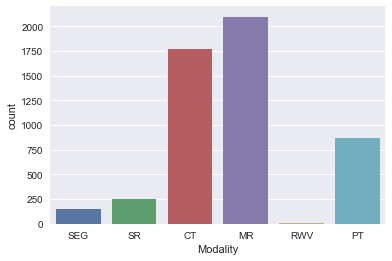

In [32]:
ax = sns.countplot(x="Modality", data=tables['CompositeContext'])
plt.show()

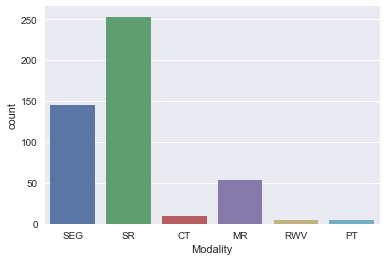

In [74]:
seriesCompositeContext = tables['CompositeContext'].drop_duplicates(subset="SeriesInstanceUID")
ax = sns.countplot(x="Modality", data=seriesCompositeContext)
plt.show()

## Variability of the acquisition parameters

### LIDC subset

In [75]:
seriesCompositeContext['PatientID'].unique()

array(['LIDC-IDRI-0001', 'LIDC-IDRI-0002', 'LIDC-IDRI-0003',
       'LIDC-IDRI-0004', 'LIDC-IDRI-0005', 'PCAMPMRI-00001',
       'PCAMPMRI-00002', 'PCAMPMRI-00003', 'QIN-HEADNECK-01-0003',
       'QIN-HEADNECK-01-0017', 'QIN-HEADNECK-01-0024',
       'QIN-HEADNECK-01-0026', 'TCGA-06-0119', 'TCGA-06-0122',
       'TCGA-06-0130', 'TCGA-06-0137', 'TCGA-06-0138', 'TCGA-CS-5396',
       'TCGA-CS-5397', 'TCGA-CS-6186', 'TCGA-CS-6188', 'TCGA-CS-6665'], dtype=object)

Some values are assigned `NaN` when the attribute was not available in the processed DICOM file.

In [77]:
# Get the subset for the LIDC collection patients
lidcCompositeContext = seriesCompositeContext[seriesCompositeContext["Collection"]=="LIDC-IDRI"]
lidcCTSeries = lidcCompositeContext[lidcCompositeContext['Modality']=='CT']

In [78]:
tables['CT'].columns

Index(['Columns', 'ConvolutionKernel', 'DistanceSourceToDetector',
       'DistanceSourceToPatient', 'Exposure', 'ExposureTime', 'FilterType',
       'FocalSpots', 'FrameOfReferenceUID', 'GeneratorPower',
       'ImageOrientationPatient', 'ImagePositionPatient', 'PixelSpacing',
       'ReconstructionDiameter', 'RotationDirection', 'Rows', 'SOPInstanceUID',
       'SliceThickness', 'XRayTubeCurrent'],
      dtype='object')

In [79]:
tables['CT'][tables['CT']['SOPInstanceUID'].isin(lidcCTSeries['SOPInstanceUID'])]

,Columns,ConvolutionKernel,DistanceSourceToDetector,DistanceSourceToPatient,Exposure,ExposureTime,FilterType,FocalSpots,FrameOfReferenceUID,GeneratorPower,ImageOrientationPatient,ImagePositionPatient,PixelSpacing,ReconstructionDiameter,RotationDirection,Rows,SOPInstanceUID,SliceThickness,XRayTubeCurrent
0,512,STANDARD,949.075012,541.0,4684,570,BODY FILTER,1.2,1.3.6.1.4.1.14519.5.2.1.6279.6001.229925374658...,48000,1.000000/0.000000/0.000000/0.000000/1.000000/0...,-166.000000/-171.699997/-135.000000,0.703125/0.703125,360.0,CW,512,1.3.6.1.4.1.14519.5.2.1.6279.6001.100954823835...,2.50,400
133,512,STANDARD,949.075012,541.0,10,478,BODY FILTER,1.2,1.3.6.1.4.1.14519.5.2.1.6279.6001.317612173882...,52800,1.000000/0.000000/0.000000/0.000000/1.000000/0...,-175.500000/-174.500000/-68.250000,0.681641/0.681641,349.0,CW,512,1.3.6.1.4.1.14519.5.2.1.6279.6001.100209095415...,1.25,440
394,512,STANDARD,949.075012,541.0,32,1160,BODY FILTER,1.2,1.3.6.1.4.1.14519.5.2.1.6279.6001.306545618788...,36000,1.000000/0.000000/0.000000/0.000000/1.000000/0...,-228.800003/-210.000000/-259.000000,0.820312/0.820312,420.0,CW,512,1.3.6.1.4.1.14519.5.2.1.6279.6001.101174865753...,2.50,300
534,512,STANDARD,949.075012,541.0,14,690,BODY FILTER,1.2,1.3.6.1.4.1.14519.5.2.1.6279.6001.214276387565...,52800,1.000000/0.000000/0.000000/0.000000/1.000000/0...,-234.800003/-170.500000/-296.250000,0.822266/0.822266,421.0,CW,512,1.3.6.1.4.1.14519.5.2.1.6279.6001.100628754219...,1.25,440
775,512,STANDARD,949.075012,541.0,4684,570,BODY FILTER,1.2,1.3.6.1.4.1.14519.5.2.1.6279.6001.133150562421...,48000,1.000000/0.000000/0.000000/0.000000/1.000000/0...,-163.300003/-170.000000/-232.544998,0.664062/0.664062,340.0,CW,512,1.3.6.1.4.1.14519.5.2.1.6279.6001.103002913993...,2.50,400


### QIN-PROSTATE-Repeatability subset

In [38]:
# Get the subset for the QIN-PROSTATE-Repeatability collection patients
pcCompositeContext = seriesCompositeContext[seriesCompositeContext.PatientID.str.contains('^PCAMPMRI')]
pcMRSeries = pcCompositeContext[pcCompositeContext['Modality']=='MR']
pcMRT2Series = pcMRSeries[pcMRSeries.SeriesDescription.str.contains('^T2')]
pcMRT2Series

,BodyPartExamined,EquipmentUID,InstitutionName,ManufacturerModelName,Modality,PatientAge,PatientID,PatientName,PatientSex,PatientWeight,...,SeriesDate,SeriesDescription,SeriesInstanceUID,SeriesTime,SoftwareVersions,StationName,StudyDate,StudyDescription,StudyInstanceUID,StudyTime
1049,PROSTATE,NaN,NaN,Signa HDxt,MR,076Y,PCAMPMRI-00001,PCAMPMRI-00001,M,72.575,...,19940620,T2 Weighted Axial,1.3.6.1.4.1.14519.5.2.1.3671.4754.983460207615...,94429.0,15/LX/MR Software release:15.0_M4A_0947.a,NaN,19940620,M2197/PRO/BD Pelvis w,1.3.6.1.4.1.14519.5.2.1.3671.4754.121472087445...,92715.0
1122,PROSTATE,NaN,NaN,Signa HDxt,MR,076Y,PCAMPMRI-00001,PCAMPMRI-00001,M,72.575,...,19940702,T2 Weighted Axial,1.3.6.1.4.1.14519.5.2.1.3671.4754.609837242670...,133813.0,15/LX/MR Software release:15.0_M4A_0947.a,NaN,19940702,M2197/BD/PRO Pelvis w,1.3.6.1.4.1.14519.5.2.1.3671.4754.288848219213...,132531.0
1161,PROSTATE,NaN,NaN,Signa HDxt,MR,046Y,PCAMPMRI-00002,PCAMPMRI-00002,M,99.790,...,19940709,T2 Weighted Axial,1.3.6.1.4.1.14519.5.2.1.3671.4754.191214456779...,123250.0,15/LX/MR Software release:15.0_M4A_0947.a,NaN,19940709,MR027 MR RECTUM (SCH),1.3.6.1.4.1.14519.5.2.1.3671.4754.304001015100...,121716.0
1268,PROSTATE,NaN,NaN,Signa HDxt,MR,046Y,PCAMPMRI-00002,PCAMPMRI-00002,M,99.790,...,19940723,T2 Weighted Axial,1.3.6.1.4.1.14519.5.2.1.3671.4754.322350301601...,133829.0,15/LX/MR Software release:15.0_M4A_0947.a,NaN,19940723,M2197/BD/PRO Pelvis w,1.3.6.1.4.1.14519.5.2.1.3671.4754.568383070573...,132116.0
1322,PROSTATE,NaN,NaN,Signa HDxt,MR,059Y,PCAMPMRI-00003,PCAMPMRI-00003,M,98.430,...,19940811,T2 Weighted Axial,1.3.6.1.4.1.14519.5.2.1.3671.4754.165941479363...,142436.0,15/LX/MR Software release:15.0_M4A_0947.a,NaN,19940811,M2197/PRO/BD Pelvis w,1.3.6.1.4.1.14519.5.2.1.3671.4754.162322077241...,141233.0
1397,PROSTATE,NaN,NaN,Signa HDxt,MR,059Y,PCAMPMRI-00003,PCAMPMRI-00003,M,99.790,...,19940825,T2 Weighted Axial,1.3.6.1.4.1.14519.5.2.1.3671.4754.325025234684...,114258.0,15/LX/MR Software release:15.0_M4A_0947.a,NaN,19940825,M2197/PRO/BD Pelvis w,1.3.6.1.4.1.14519.5.2.1.3671.4754.263464522348...,113959.0


In [39]:
tables['MR'][tables['MR']['SOPInstanceUID'].isin(pcMRT2Series['SOPInstanceUID'])]

,AcquisitionMatrix,EchoNumbers,EchoTime,FlipAngle,ImagingFrequency,InPlanePhaseEncodingDirection,InversionTime,MagneticFieldStrength,NumberOfEchoes,PixelBandwidth,PixelSpacing,PulseSequenceName,RepetitionTime,SOPInstanceUID,ScanningSequence,SequenceVariant,SliceThickness,TriggerTime
36,0/384/224/0,1,104.800,90,127.737007,ROW,0.0,3.0,NaN,122.07,0.3125/0.3125,NaN,4000.0,1.3.6.1.4.1.14519.5.2.1.3671.4754.102262714390...,SE,SK/OSP,3.0,NaN
100,0/384/224/0,1,97.200,90,127.737046,ROW,0.0,3.0,NaN,122.07,0.2734/0.2734,NaN,3350.0,1.3.6.1.4.1.14519.5.2.1.3671.4754.102727114215...,SE,SK/OSP,3.0,NaN
130,0/384/224/0,1,97.992,90,127.737037,ROW,0.0,3.0,NaN,122.07,0.3125/0.3125,NaN,4000.0,1.3.6.1.4.1.14519.5.2.1.3671.4754.113359650371...,SE,SK/OSP,3.0,NaN
228,0/384/224/0,1,99.720,90,127.737030,ROW,0.0,3.0,NaN,122.07,0.3125/0.3125,NaN,3600.0,1.3.6.1.4.1.14519.5.2.1.3671.4754.133924958971...,SE,SK/OSP,3.0,NaN
274,0/384/224/0,1,100.080,90,127.737065,ROW,0.0,3.0,NaN,122.07,0.3125/0.3125,NaN,3600.0,1.3.6.1.4.1.14519.5.2.1.3671.4754.100165068464...,SE,SK/OSP,3.0,NaN
340,0/384/224/0,1,99.504,90,127.737002,ROW,0.0,3.0,NaN,122.07,0.3125/0.3125,NaN,3650.0,1.3.6.1.4.1.14519.5.2.1.3671.4754.107174429242...,SE,SK/OSP,3.0,NaN


## Segmentations

In [44]:
# Get all of the DICOM Segmentation objects
segCompositeContext = seriesCompositeContext[seriesCompositeContext.PatientID.str.contains('^LIDC-IDRI')]
# note that to be more precise, we could use SOPClassUID that uniquely identifies DICOM object class
segInstances = tables['CompositeContext'][tables['CompositeContext']['Modality']=='SEG']
segInstances.shape

(145, 23)

In [45]:
segmentations = tables['SEG'][tables['SEG']['SOPInstanceUID'].isin(segInstances['SOPInstanceUID'])]

TODO: figure about how segmentations/segments are organized
Code tuples

In [47]:
segments = tables['SEG_Segments'][tables['SEG_Segments']['SOPInstanceUID'].isin(segInstances['SOPInstanceUID'])]
segments

,AnatomicRegionSequence_CodeMeaning,AnatomicRegionSequence_CodeValue,AnatomicRegionSequence_CodingSchemeDesignator,SOPInstanceUID,SegmentAlgorithmName,SegmentAlgorithmType,SegmentLabel,SegmentNumber,SegmentedPropertyCategoryCodeSequence_CodeMeaning,SegmentedPropertyCategoryCodeSequence_CodeValue,SegmentedPropertyCategoryCodeSequence_CodingSchemeDesignator,SegmentedPropertyTypeCodeSequence_CodeMeaning,SegmentedPropertyTypeCodeSequence_CodeValue,SegmentedPropertyTypeCodeSequence_CodingSchemeDesignator
0,Lung,T-28000,SRT,1.2.276.0.7230010.3.1.4.0.1464.1535579216.777705,NaN,MANUAL,Nodule,1,Morphological Abnormal Structure,M-01000,SRT,Nodule,M-03010,SRT
1,Lung,T-28000,SRT,1.2.276.0.7230010.3.1.4.0.1503.1535579222.290092,NaN,MANUAL,Nodule,1,Morphological Abnormal Structure,M-01000,SRT,Nodule,M-03010,SRT
2,Lung,T-28000,SRT,1.2.276.0.7230010.3.1.4.0.1598.1535579226.955417,NaN,MANUAL,Nodule,1,Morphological Abnormal Structure,M-01000,SRT,Nodule,M-03010,SRT
3,Lung,T-28000,SRT,1.2.276.0.7230010.3.1.4.0.1682.1535579231.637897,NaN,MANUAL,Nodule,1,Morphological Abnormal Structure,M-01000,SRT,Nodule,M-03010,SRT
4,Lung,T-28000,SRT,1.2.276.0.7230010.3.1.4.0.1689.1535579239.884864,NaN,MANUAL,Nodule,1,Morphological Abnormal Structure,M-01000,SRT,Nodule,M-03010,SRT
5,Lung,T-28000,SRT,1.2.276.0.7230010.3.1.4.0.1704.1535579248.558518,NaN,MANUAL,Nodule,1,Morphological Abnormal Structure,M-01000,SRT,Nodule,M-03010,SRT
6,Lung,T-28000,SRT,1.2.276.0.7230010.3.1.4.0.1738.1535579273.363117,NaN,MANUAL,Nodule,1,Morphological Abnormal Structure,M-01000,SRT,Nodule,M-03010,SRT
7,Lung,T-28000,SRT,1.2.276.0.7230010.3.1.4.0.1745.1535579277.449818,NaN,MANUAL,Nodule,1,Morphological Abnormal Structure,M-01000,SRT,Nodule,M-03010,SRT
8,Lung,T-28000,SRT,1.2.276.0.7230010.3.1.4.0.1747.1535579281.570167,NaN,MANUAL,Nodule,1,Morphological Abnormal Structure,M-01000,SRT,Nodule,M-03010,SRT
9,Lung,T-28000,SRT,1.2.276.0.7230010.3.1.4.0.1754.1535579285.837256,NaN,MANUAL,Nodule,1,Morphological Abnormal Structure,M-01000,SRT,Nodule,M-03010,SRT


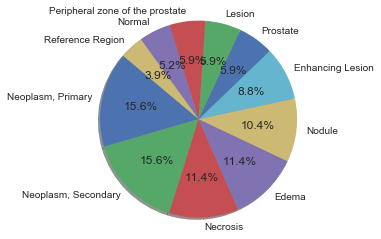

In [61]:
segmentationTypeCount = segments['SegmentedPropertyTypeCodeSequence_CodeMeaning'].value_counts()
plt.pie(segmentationTypeCount.values, labels=segmentationTypeCount.keys(), 
        autopct='%1.1f%%', shadow=True, startangle=140)
 
plt.axis('equal')
plt.show()

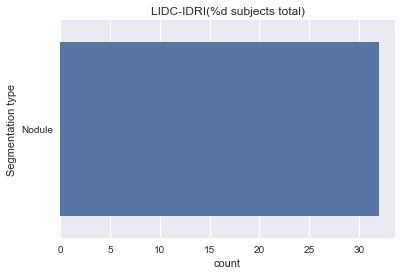

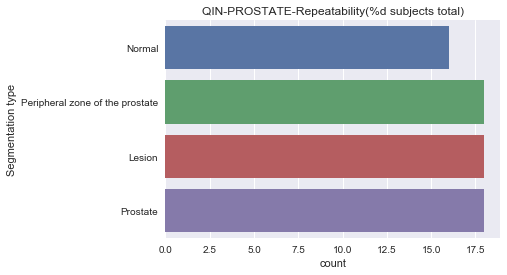

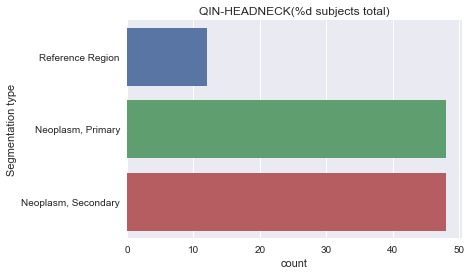

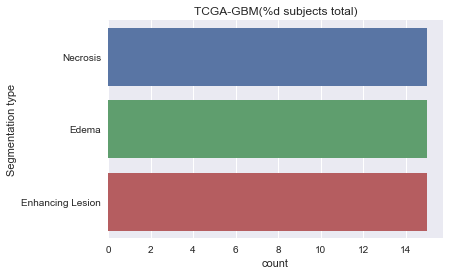

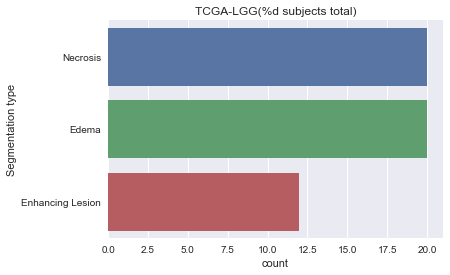

In [122]:
# distribution of the segmentation types over image collections
segmentsMerged = pd.merge(tables["CompositeContext"],segments,on="SOPInstanceUID")
for c in segmentsMerged["Collection"].unique():
  ax=sns.countplot(data=segmentsMerged[segmentsMerged["Collection"]==c],
                   y='SegmentedPropertyTypeCodeSequence_CodeMeaning') 
  ax.set_title(c)
  ax.set_ylabel("Segmentation type")
  plt.show()

In [119]:
# Distribution of segmentations over collections and modalities
# Need to establish which referenced series/instance segmentation corresponds to!
# For this, we have the References table:
tables["References"].columns

Index(['ReferencedSOPClassUID', 'ReferencedSOPInstanceUID', 'SOPInstanceUID',
       'SeriesInstanceUID'],
      dtype='object')

In [151]:
# how many segments we have total?
segmentsMerged.groupby(["SOPInstanceUID","SegmentNumber"]).size()

SOPInstanceUID                                             SegmentNumber
1.2.276.0.7230010.3.1.4.0.1464.1535579216.777705           1                1
1.2.276.0.7230010.3.1.4.0.1503.1535579222.290092           1                1
1.2.276.0.7230010.3.1.4.0.1598.1535579226.955417           1                1
1.2.276.0.7230010.3.1.4.0.1682.1535579231.637897           1                1
1.2.276.0.7230010.3.1.4.0.1689.1535579239.884864           1                1
1.2.276.0.7230010.3.1.4.0.1704.1535579248.558518           1                1
1.2.276.0.7230010.3.1.4.0.1738.1535579273.363117           1                1
1.2.276.0.7230010.3.1.4.0.1745.1535579277.449818           1                1
1.2.276.0.7230010.3.1.4.0.1747.1535579281.570167           1                1
1.2.276.0.7230010.3.1.4.0.1754.1535579285.837256           1                1
1.2.276.0.7230010.3.1.4.0.1761.1535579290.247790           1                1
1.2.276.0.7230010.3.1.4.0.1768.1535579294.62796            1         

In [138]:
# how many of the segments include references to the images they correspond to?
segmentsMerged["SOPInstanceUID"].isin(tables["References"]["SOPInstanceUID"]).describe()

count      307
unique       1
top       True
freq       307
Name: SOPInstanceUID, dtype: object

In [164]:
tables["CompositeContext"][tables["CompositeContext"]["SOPInstanceUID"]=='1.2.276.0.7230010.3.1.4.8323329.3188113.1531852437.107139']['Modality'].values[0]

'SEG'

In [273]:
# note that 
segmentsRefsMerged = pd.merge(tables["References"].drop_duplicates(subset="SOPInstanceUID"),
                              segmentsMerged,on="SOPInstanceUID")
segmentsRefsMerged["ReferencedModality"] = [tables["CompositeContext"][tables["CompositeContext"]["SOPInstanceUID"]==x]["Modality"].values[0] 
                      for x in segmentsRefsMerged["ReferencedSOPInstanceUID"]]
segmentsRefsMerged.columns

Index(['ReferencedSOPClassUID', 'ReferencedSOPInstanceUID', 'SOPInstanceUID',
       'SeriesInstanceUID_x', 'BodyPartExamined', 'EquipmentUID',
       'InstitutionName', 'ManufacturerModelName', 'Modality', 'PatientAge',
       'PatientID', 'PatientName', 'PatientSex', 'PatientWeight', 'ProductId',
       'SOPClassUID', 'SeriesDate', 'SeriesDescription', 'SeriesInstanceUID_y',
       'SeriesTime', 'SoftwareVersions', 'StationName', 'StudyDate',
       'StudyDescription', 'StudyInstanceUID', 'StudyTime', 'Collection',
       'AnatomicRegionSequence_CodeMeaning',
       'AnatomicRegionSequence_CodeValue',
       'AnatomicRegionSequence_CodingSchemeDesignator', 'SegmentAlgorithmName',
       'SegmentAlgorithmType', 'SegmentLabel', 'SegmentNumber',
       'SegmentedPropertyCategoryCodeSequence_CodeMeaning',
       'SegmentedPropertyCategoryCodeSequence_CodeValue',
       'SegmentedPropertyCategoryCodeSequence_CodingSchemeDesignator',
       'SegmentedPropertyTypeCodeSequence_CodeMeaning',


/Users/fedorov/.pyenv/versions/3.5.3/Python.framework/Versions/3.5/lib/python3.5/site-packages/seaborn/axisgrid.py:703: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


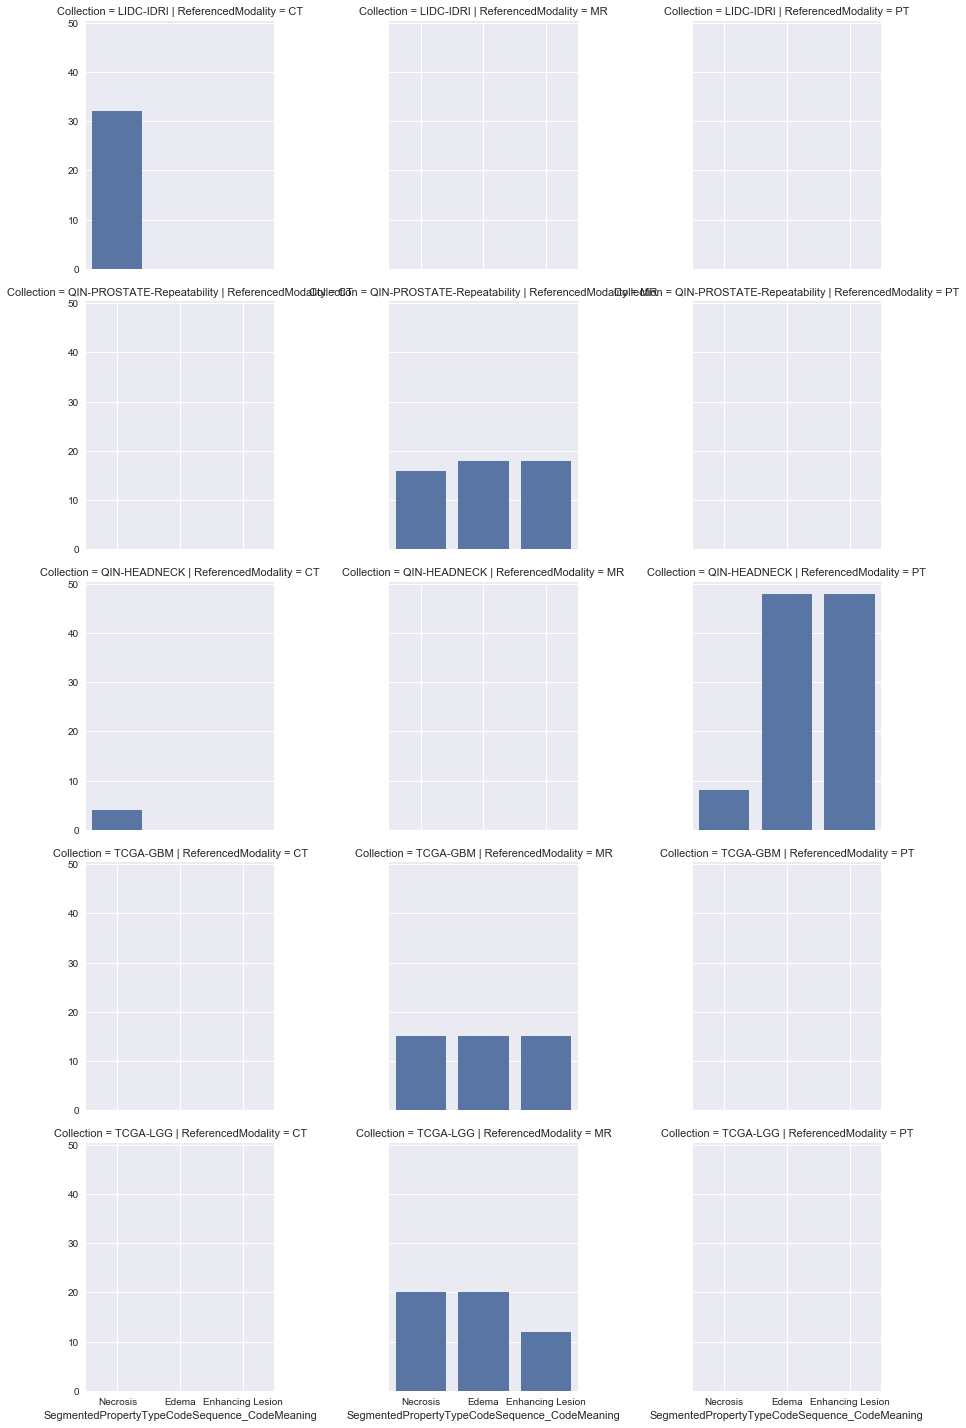

In [170]:
g=sns.FacetGrid(segmentsRefsMerged, row="Collection", col="ReferencedModality", size=4)
g.map(sns.countplot, "SegmentedPropertyTypeCodeSequence_CodeMeaning")
g.add_legend()
plt.show()

## Measurements

In [172]:
tables["SR1500_Measurements"].shape

(29612, 15)

In [173]:
tables["SR1500_Measurements"].columns

Index(['SOPInstanceUID', 'TrackingUniqueIdentifier',
       'derivationModifier_CodeMeaning', 'derivationModifier_CodeValue',
       'derivationModifier_CodingSchemeDesignator',
       'measurementMethod_CodeMeaning', 'measurementMethod_CodeValue',
       'measurementMethod_CodingSchemeDesignator', 'quantity_CodeMeaning',
       'quantity_CodeValue', 'quantity_CodingSchemeDesignator',
       'units_CodeMeaning', 'units_CodeValue', 'units_CodingSchemeDesignator',
       'value'],
      dtype='object')

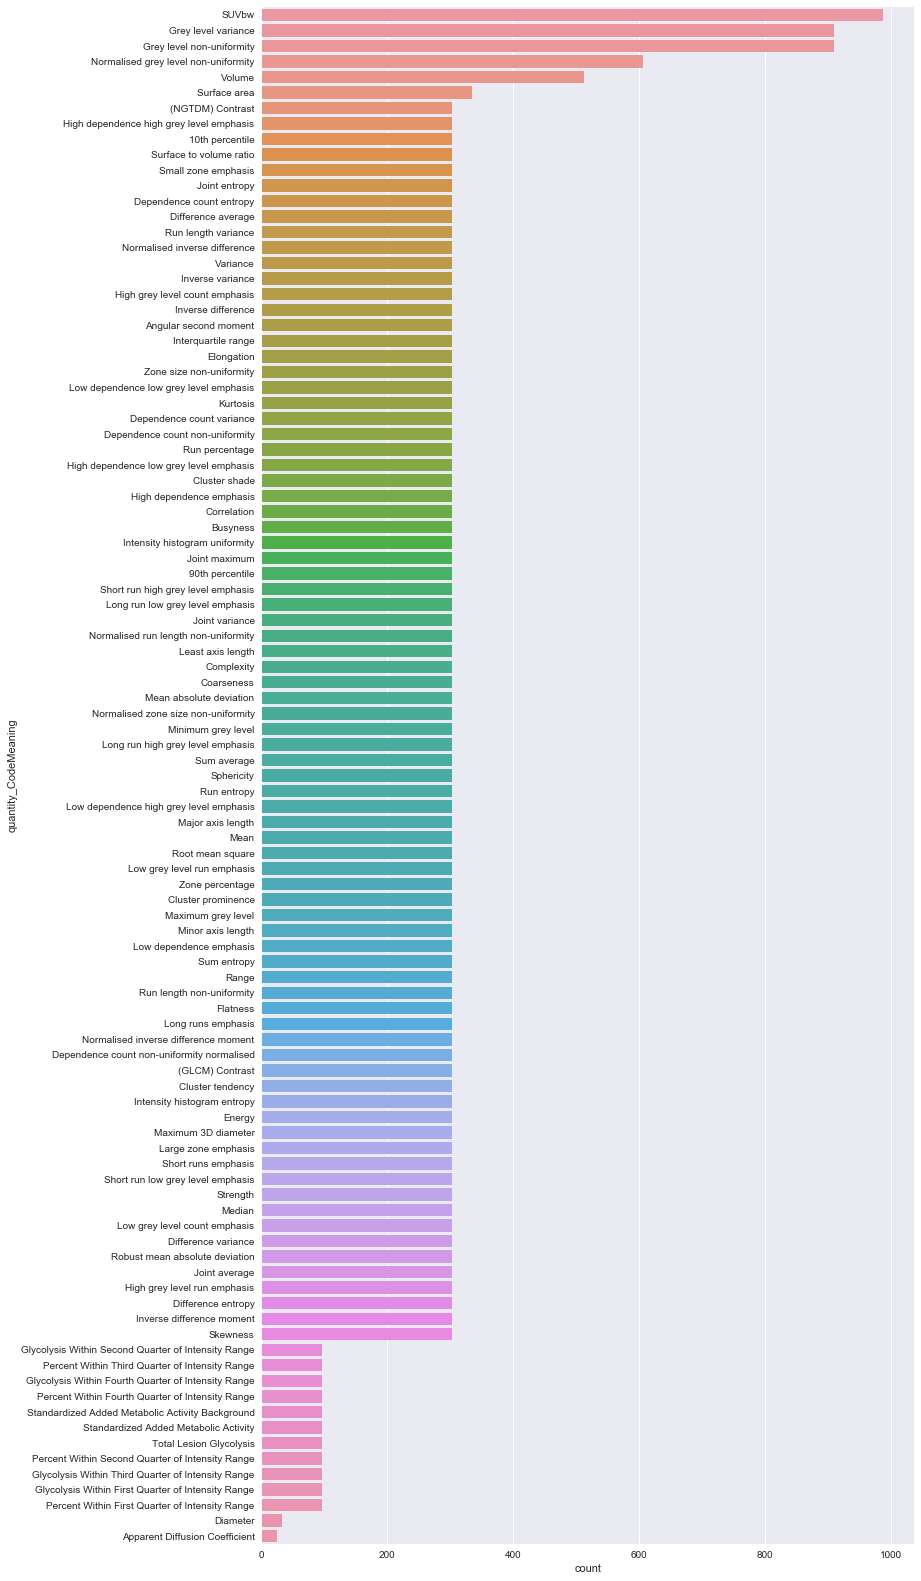

In [186]:
from matplotlib import pyplot
a4_dims = (11.7, 28.27)

fig, ax = pyplot.subplots(figsize=a4_dims)

sns.countplot(ax=ax,data=tables["SR1500_Measurements"], 
              y="quantity_CodeMeaning",
              order = tables["SR1500_Measurements"]["quantity_CodeMeaning"].value_counts().index)
plt.show()

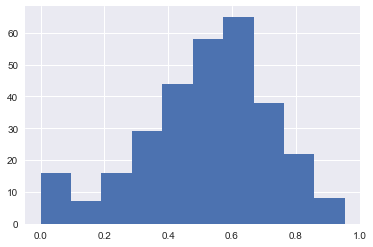

In [201]:
# Examine distribution of individual feature values: Sphericity, Coarseness, ...
plt.hist(tables["SR1500_Measurements"][tables["SR1500_Measurements"]["quantity_CodeMeaning"]=="Flatness"]["value"].values)
plt.show()

In [203]:
tables["SR1500_Measurements"].shape

(29612, 15)

In [223]:
# scatter plot showing dependency of individual features by collection/modality
# First, get references to the modalities these measurements correspond to
measurementsMerged = pd.merge(tables["CompositeContext"],tables["SR1500_Measurements"],on="SOPInstanceUID")
measurementsRefsMerged = pd.merge(tables["References"].drop_duplicates(subset="SOPInstanceUID"),
                              measurementsMerged,on="SOPInstanceUID")
measurementsRefsMerged["ReferencedModality"] = [tables["CompositeContext"][tables["CompositeContext"]["SOPInstanceUID"]==x]["Modality"].values[0] 
                      for x in measurementsRefsMerged["ReferencedSOPInstanceUID"]]
measurementsRefsMerged.shape

(29612, 42)

In [224]:
measurementsRefsMerged.columns

Index(['ReferencedSOPClassUID', 'ReferencedSOPInstanceUID', 'SOPInstanceUID',
       'SeriesInstanceUID_x', 'BodyPartExamined', 'EquipmentUID',
       'InstitutionName', 'ManufacturerModelName', 'Modality', 'PatientAge',
       'PatientID', 'PatientName', 'PatientSex', 'PatientWeight', 'ProductId',
       'SOPClassUID', 'SeriesDate', 'SeriesDescription', 'SeriesInstanceUID_y',
       'SeriesTime', 'SoftwareVersions', 'StationName', 'StudyDate',
       'StudyDescription', 'StudyInstanceUID', 'StudyTime', 'Collection',
       'TrackingUniqueIdentifier', 'derivationModifier_CodeMeaning',
       'derivationModifier_CodeValue',
       'derivationModifier_CodingSchemeDesignator',
       'measurementMethod_CodeMeaning', 'measurementMethod_CodeValue',
       'measurementMethod_CodingSchemeDesignator', 'quantity_CodeMeaning',
       'quantity_CodeValue', 'quantity_CodingSchemeDesignator',
       'units_CodeMeaning', 'units_CodeValue', 'units_CodingSchemeDesignator',
       'value', 'ReferencedM

['LIDC-IDRI' 'QIN-PROSTATE-Repeatability' 'QIN-HEADNECK' 'TCGA-GBM'
 'TCGA-LGG']


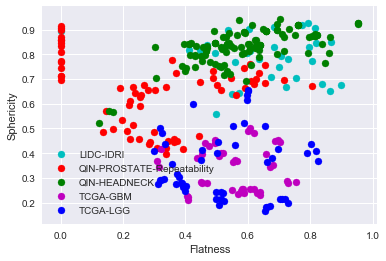

In [255]:
# NB: This assumes both covariates belong to the same measurement group 
covariate1="Flatness" # try Energy
covariate2="Sphericity"

collections=measurementsRefsMerged["Collection"].unique()
print(collections)
colors=['c','r','g','m','b']

for collection, color in zip(collections,colors):
  collectionMeasurements = measurementsRefsMerged[measurementsRefsMerged["Collection"]==collection]
  plt.scatter(collectionMeasurements[collectionMeasurements["quantity_CodeMeaning"]==covariate1]["value"].values, 
              collectionMeasurements[collectionMeasurements["quantity_CodeMeaning"]==covariate2]["value"].values,
              c=color,label=collection)
plt.legend()
plt.xlabel(x)
plt.ylabel(y)
plt.show()